![](../logo.png)

# Softmax regression
## Yoav Ram

Softmax regression, or **multinomial logistic regression**, is a generalization of logistic regression used for multiclass classification problems. While logistic regression handles binary classification (two classes, $k=2$), softmax regression extends it to classify instances into one of  $k$ classes ($k>2$).

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import jax.numpy as np
import jax
from jax import random
from jax.scipy import stats, optimize
from jax.scipy.special import expit, logit
import pandas as pd
import seaborn as sns
sns.set(
    style='white',
    context='talk'
)
red, blue, green = sns.color_palette('Set1', 3)
from sklearn.metrics import confusion_matrix

# MNIST dataset: image classification

We'll use a classical image classification problem, the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset of  handwritten digits. 
Since we will use Keras later anyway, we can get the images from the `keras.datasets` module which is distributed with Keras.

In [14]:
import keras
(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()
X_train, X_test = (X_train/255).astype(np.float32), (X_test/255).astype(np.float32)

Each sample in this dataset is 28x28 pixles-which are our 784 features.
Each image shows a single handwritten digit, so our target is one of 10 classes (0,1,2,3,4,5,6,7,8,9).
We scaled the pixels to be between 0 and 1 - this is important for linear models and the pixel values is arbitrary anyway.

MNIST is already split to train and test sets with 60K and 10K images in each set.

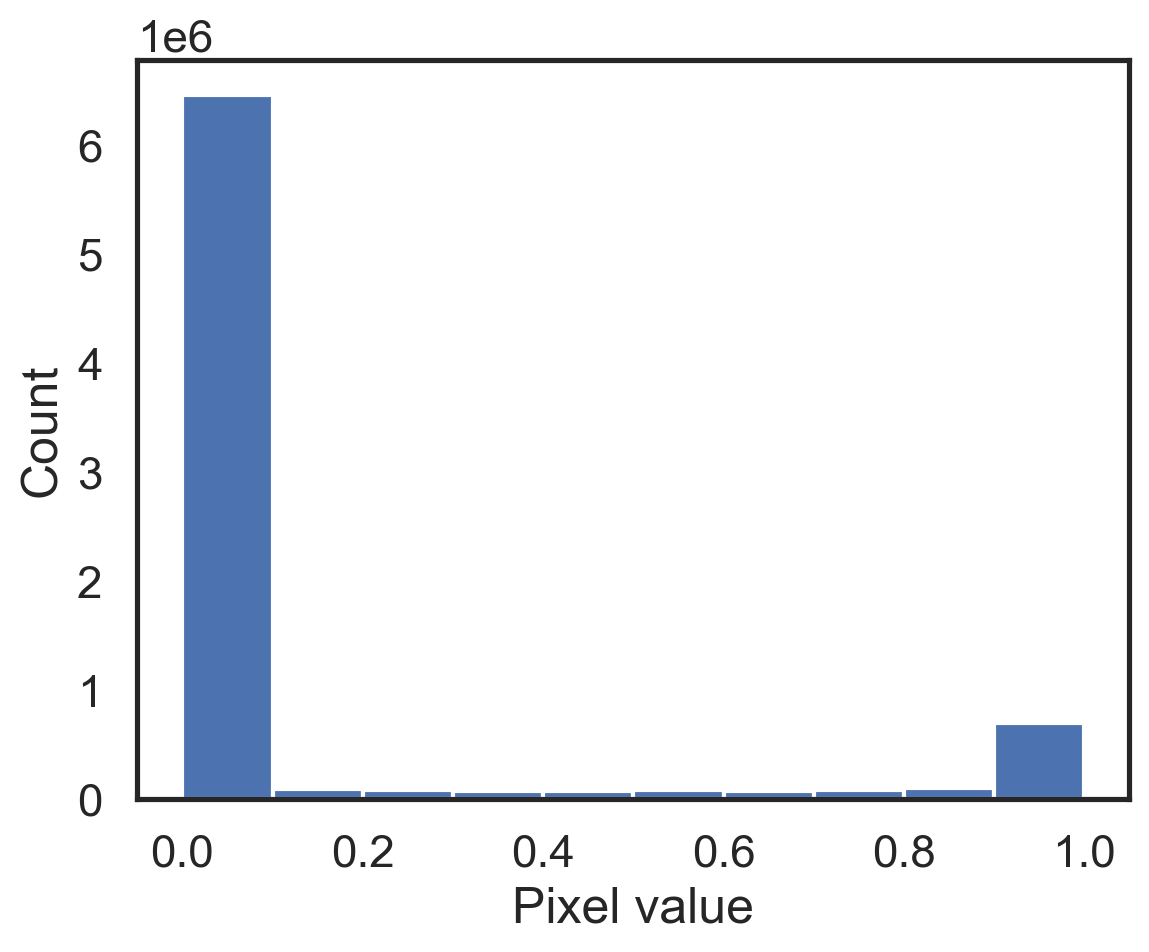

In [15]:
plt.hist(X_test.ravel())
plt.xlabel('Pixel value')
plt.ylabel('Count');

7


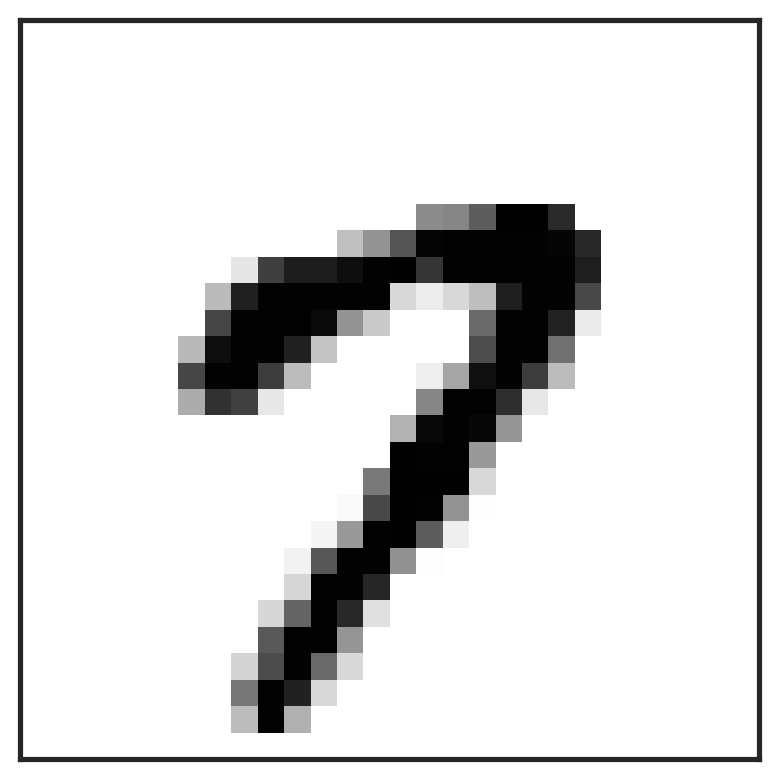

In [16]:
def display_image(im, ax=None):
    if ax is None: fig, ax = plt.subplots()
    ax.imshow(im, cmap='gray_r')
    ax.set_xticks([])
    ax.set_yticks([])

idx = 15
display_image(X_train[idx, :, :])
print(Y_train[idx])

# Softmax regression

Let's write the model, which is going to be another example of a **generalized linear model**.
This model is just an extension of the binary logistic regression model (ProbML ch. 10.3).
The probability $p(y_i=k \mid x_i)$ that image $i$ shows digit $k$ is
$$
z_{i,k} = \sum_{j=1}^{m} a_{j,k}\; x_{i,j} $$
$$
\hat{y}_{i,k} = \text{softmax}{(z_{i,k})} = \frac{e^{z_{i,k}}}{\sum_{t=0}^{9}{e^{z_{i,t}}}} $$
$$
y_i \sim \text{Cat}\left(\hat{y}_i=(\hat{y}_{i,0}, \ldots, \hat{y}_{i,9})\right)
$$
where $m=784$ is the number of pixels (features) and $a_{j,k}$ is the effect of $j$ pixel on the logit for digit $k$.
This defines **softmax** as the extension of the expit/logistic function (ProbML ch. 2.5.2).

$\text{Cat}$ is categorical distribution (ProbML ch. 2.5), the extension of the Bernoulli distribution for multiple classes. If Bernoulli models a single coin flip, categorical models a single dice roll.

The linear model can be written in matrix form as $$
z_i = W x_i $$
$$
\hat{y}_i = \text{softmax}(z_i) $$
$$
y_i \sim \text{Cat}\left(\hat{y}_i\right)
$$

One issue is that according to this model, $y_i$ is a **one-hot encoded** vector: it contains nine 0s and a single 1. So we need to encode our data arrays accordingly. 
We do this with JAX.

In [17]:
Y_train = jax.nn.one_hot(Y_train, 10).astype(np.float32)
Y_test = jax.nn.one_hot(Y_test, 10).astype(np.float32)

Let's see some images with their labels; each time we run this cell we'll get a random image.

2
[0 0 1 0 0 0 0 0 0 0]


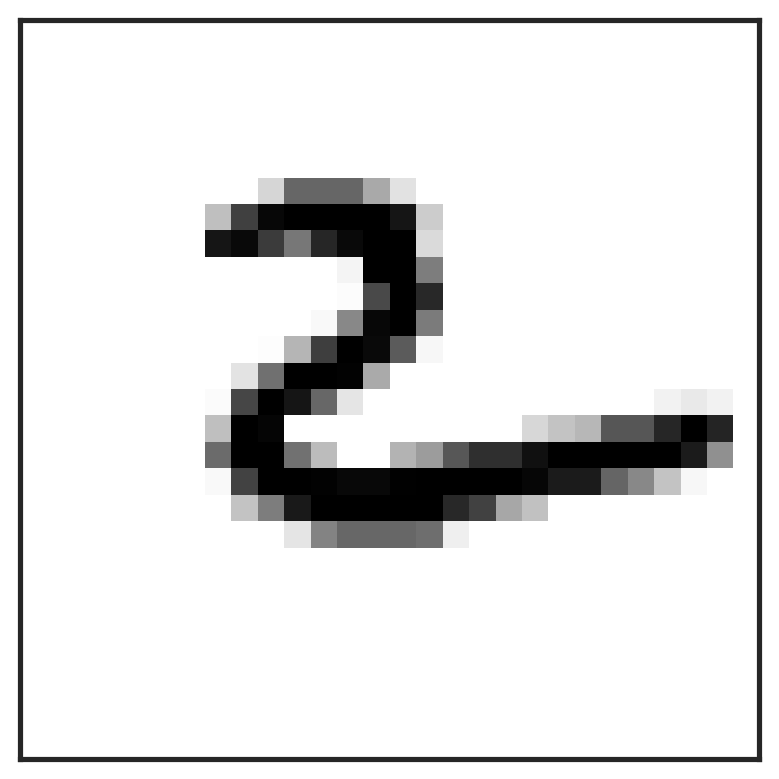

In [18]:
idx = 109
display_image(X_train[idx, :, :])
print(Y_train[idx].argmax())
print(Y_train[idx].astype(int))

Another issue is that our linear model can't handle 2D arrays (images) so we have to reshape our `X`s so that they will be of shape `(nsamples, nfeatures)`.

In [19]:
X_train = X_train.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)

# Maximum likelihood estimation

Maximum likelihood works much as before. 
The loss function is still the NLL, which now sums over the digits, $k$, as well as the images, $i$. 
$$
NLL(W) = -\frac{1}{n}\sum_{i=1}^{n}\sum_{k=0}^{9} y_{i,k} \log \hat{y}_{i,k}
$$

In [23]:
def NLL(W, X, Y, ϵ=1e-10):
    Z = X @ W # (n, 784) @ (784, 10) -> (n,10)
    Yhat = jax.nn.softmax(Z)    
    return -(Y * np.log(Yhat)).sum() / X.shape[0] # 2D sum over i and k

def accuracy(W, X, Y):
    Z = X @ W
    # no need for softmax here, it's monotone so won't change the result
    return (Z.argmax(axis=1) == Y.argmax(axis=1)).mean()

In [24]:
W = np.zeros((X_test.shape[1], Y_test.shape[1])) 
print('NLL:', NLL(W, X_test, Y_test))
print('Accuracy', accuracy(W, X_test, Y_test))

NLL: 2.302585
Accuracy 0.098


In [22]:
np.exp(2.3)

Array(9.974182, dtype=float32, weak_type=True)

To find the MLE we need to solve $\partial NLL / \partial W = 0$. 
So first we need to find the gradient.

This is easy with `jax.grad`.

In [29]:
gradient = jax.grad(NLL)
print(gradient(W, X_test[:50], Y_test[:50]))


(784, 10)


## Exercise: gradient

Write a function `mygradient(W,X,Y)` that computes the gradient w.r.t `W` and check that it gives the same result as `gradient` (which is computed with JAX).
Tip: go back to the logistic regression session.

In [ ]:
def mygradient(W, X, Y):
    ## your code here   

In [ ]:
assert np.allclose(mygradient(W, X_test, Y_test), gradient(W, X_test, Y_test), atol=1e-5)

# Stochastic gradient descent
Here too, the loss function is convex (ProbML 10.3.2.4). 

In this case, we have 60K samples in the training set and it does not make sense (in terms of efficiency) to compute the gradient on all 60K samples at every step. Instead, we will compute the gradient on a random batch of 50 samples at each step (ProbML ch. 8.4).

In [21]:
@jax.jit
def gradient_descent(W, X, Y, η=0.005):
    # gradient
    G = gradient(W, X, Y)
    assert G.shape == W.shape
    # descent
    return W - η * G

In [22]:
%%time
key = random.key(102) # for shuffling
W = np.zeros((X_train.shape[1], Y_train.shape[1]), dtype=np.float32)
n = X_train.shape[0]
batch_size = 50
epochs = 75

for batch in range(epochs * n//batch_size): 
    # once per epoch
    if batch % (n//batch_size) == 0:
        # shuffle
        key, subkey = random.split(key)
        idx = random.permutation(subkey, X_train.shape[0])
        X_train, Y_train = X_train[idx], Y_train[idx]
        # print
        print("Batch {:5d}:\tNLL: {:.6f}\tAccuracy: {:.4f}".format(
            batch, NLL(W, X_test, Y_test), accuracy(W, X_test, Y_test)))
    
    # batch
    start = (batch * batch_size) % n
    stop = start + batch_size
    X_, Y_ = X_train[start:stop, :], Y_train[start:stop, :]
    
    # descent
    W = gradient_descent(W, X_, Y_)
    
print("Batch {:5d}:\tNLL: {:.6f}\tAccuracy: {:.4f}".format(
    batch, NLL(W, X_test, Y_test), accuracy(W, X_test, Y_test)))

Batch     0:	NLL: 2.302585	Accuracy: 0.0980
Batch  1200:	NLL: 0.718504	Accuracy: 0.8559
Batch  2400:	NLL: 0.550667	Accuracy: 0.8742
Batch  3600:	NLL: 0.483880	Accuracy: 0.8832
Batch  4800:	NLL: 0.446547	Accuracy: 0.8871
Batch  6000:	NLL: 0.422028	Accuracy: 0.8921
Batch  7200:	NLL: 0.403927	Accuracy: 0.8952
Batch  8400:	NLL: 0.390706	Accuracy: 0.8974
Batch  9600:	NLL: 0.379998	Accuracy: 0.8991
Batch 10800:	NLL: 0.371956	Accuracy: 0.9008
Batch 12000:	NLL: 0.364412	Accuracy: 0.9020
Batch 13200:	NLL: 0.358039	Accuracy: 0.9039
Batch 14400:	NLL: 0.353044	Accuracy: 0.9055
Batch 15600:	NLL: 0.348139	Accuracy: 0.9064
Batch 16800:	NLL: 0.344023	Accuracy: 0.9065
Batch 18000:	NLL: 0.340437	Accuracy: 0.9072
Batch 19200:	NLL: 0.337362	Accuracy: 0.9084
Batch 20400:	NLL: 0.334640	Accuracy: 0.9088
Batch 21600:	NLL: 0.331838	Accuracy: 0.9093
Batch 22800:	NLL: 0.329356	Accuracy: 0.9093
Batch 24000:	NLL: 0.326898	Accuracy: 0.9099
Batch 25200:	NLL: 0.325012	Accuracy: 0.9103
Batch 26400:	NLL: 0.322986	Accur

# How does it work?
We can visualize how the model works by plotting each $W_k=(a_{1,k}, \ldots, a_{m,k})$ as a 28x28 mask.
We can think of this mask being applied to the image to determine the logit for digit $k$.

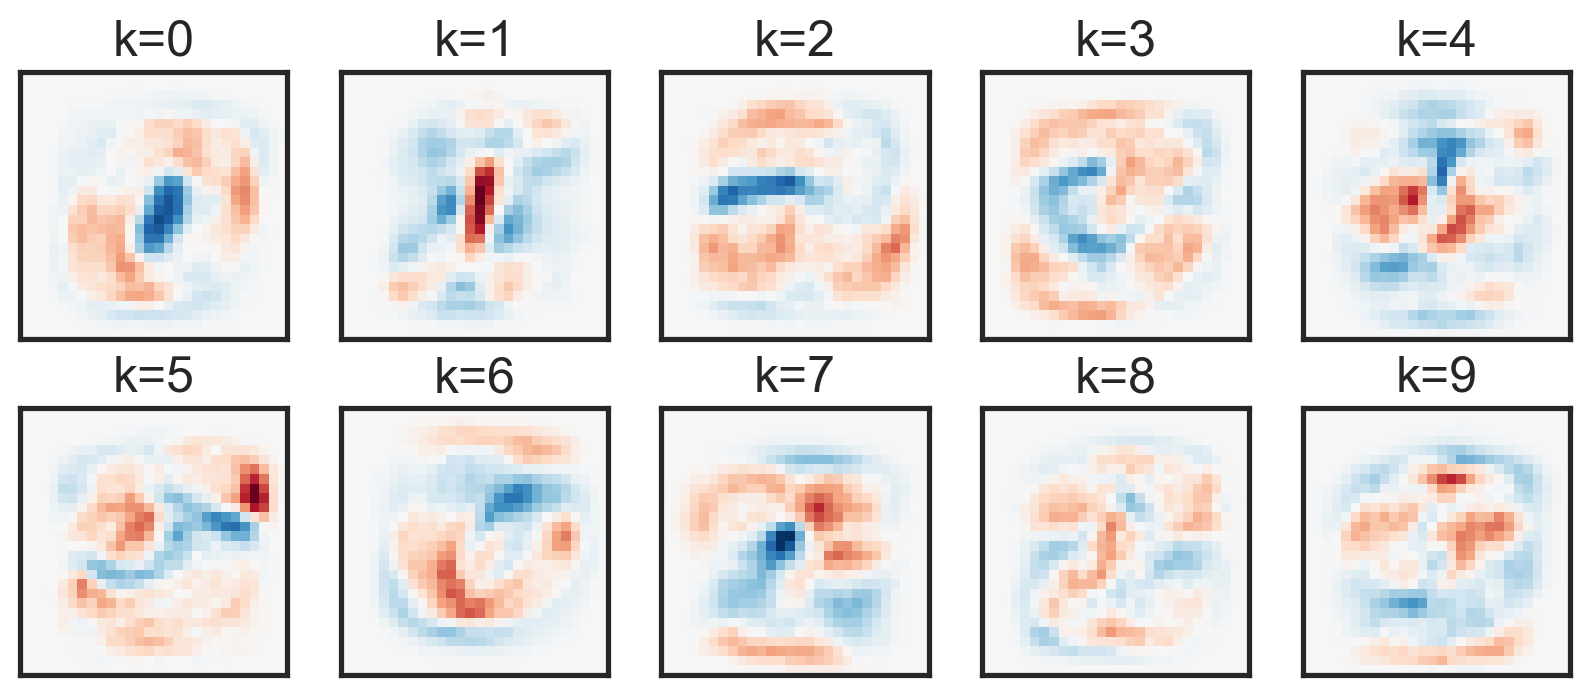

In [26]:
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for k, ax in enumerate(axes.flat):
    ax.imshow(W[:,k].reshape(28, 28), vmin=-0.65, vmax=0.65, cmap='RdBu_r')
    ax.set(xticks=[], yticks=[], title='k={}'.format(k))

# Misclassifications
Let's see some predictions:

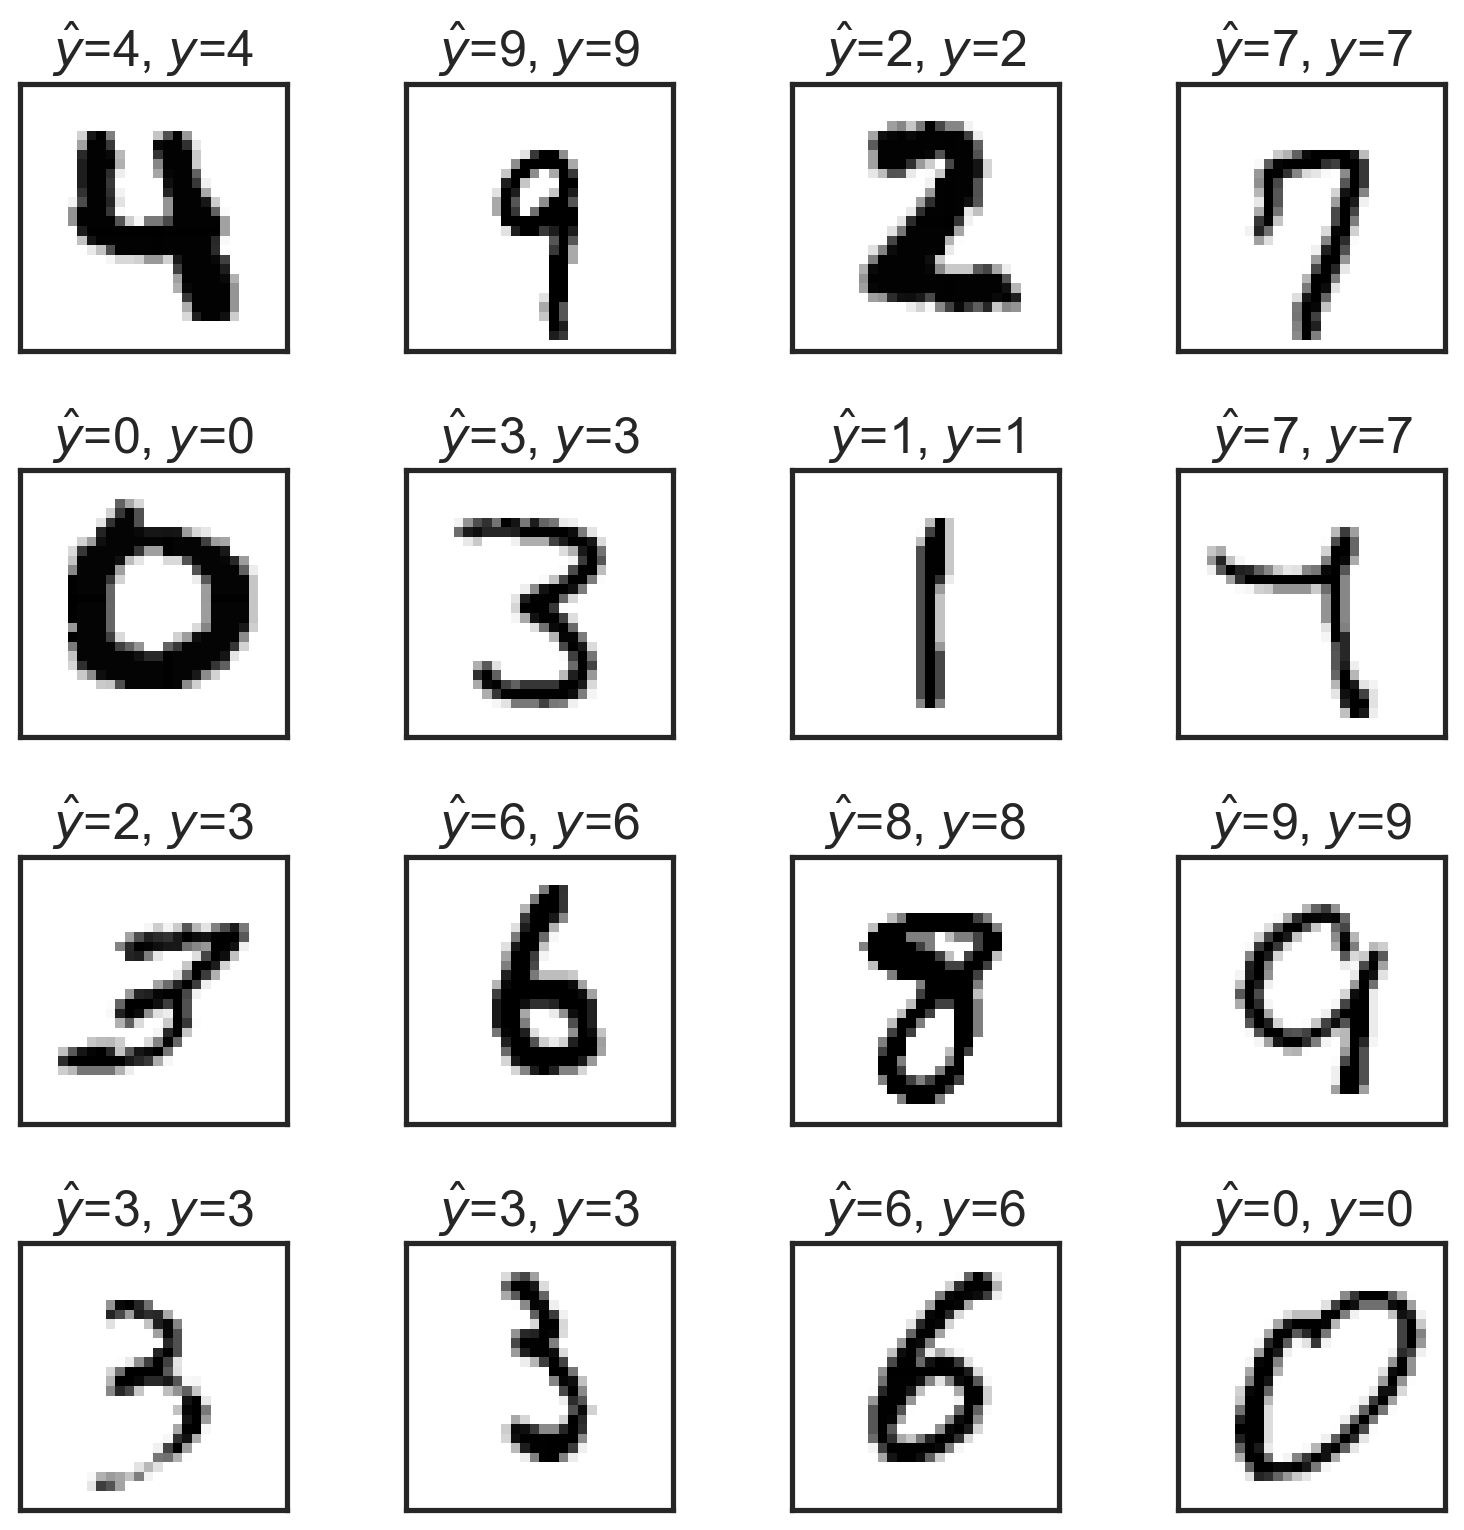

In [27]:
def predict(W, X):
    X = np.atleast_2d(X)
    Z = X @ W
    return Z.argmax(axis=1)

key, subkey = random.split(key)
idx = random.choice(subkey, X_test.shape[0], shape=(4*4,), replace=False)
fig, axes = plt.subplots(4, 4, figsize=(8,8))
for i, ax in zip(idx, axes.flat):
    display_image(X_test[i].reshape(28, 28), ax=ax)
    ax.set_title('{}={}, {}={}'.format(r'$\hat{y}$', predict(W, X_test[i])[0], r'$y$', Y_test[i].argmax()))
fig.tight_layout()

So far so good, which we expect with >90% accuracy.
What about the confusion matrix?

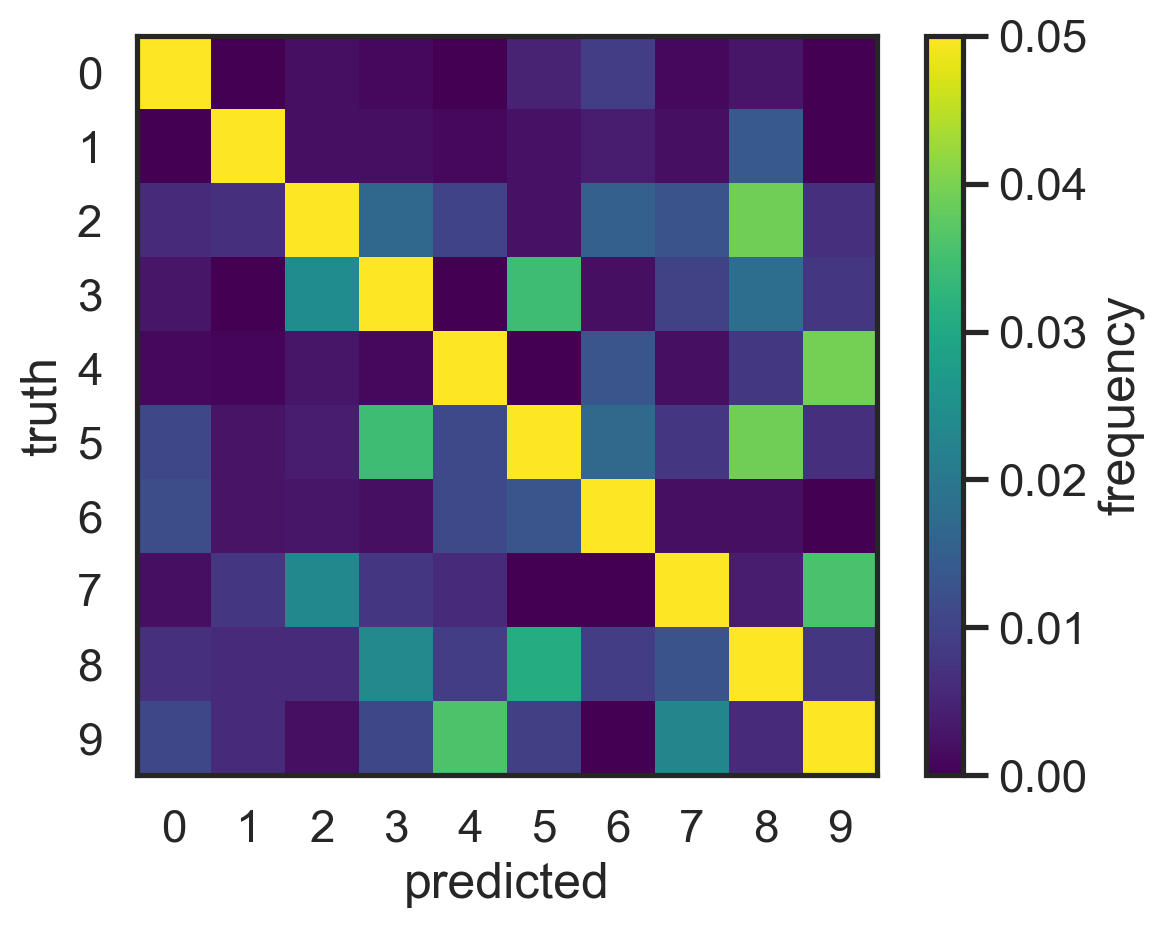

In [28]:
Y_true = Y_test.argmax(axis=1)
Y_pred = predict(W, X_test)

conf = confusion_matrix(Y_true, Y_pred, normalize='pred')
plt.imshow(conf, origin='upper', cmap='viridis', vmin=0, vmax=0.05)
plt.xlabel('predicted')
plt.ylabel('truth');
plt.xticks(range(10))
plt.yticks(range(10))
plt.colorbar(label='frequency');

We see that many of the mistakes are classifications of 2 and 5 to to 8, 9 to 4, 5 to 3... Let's see some of these.

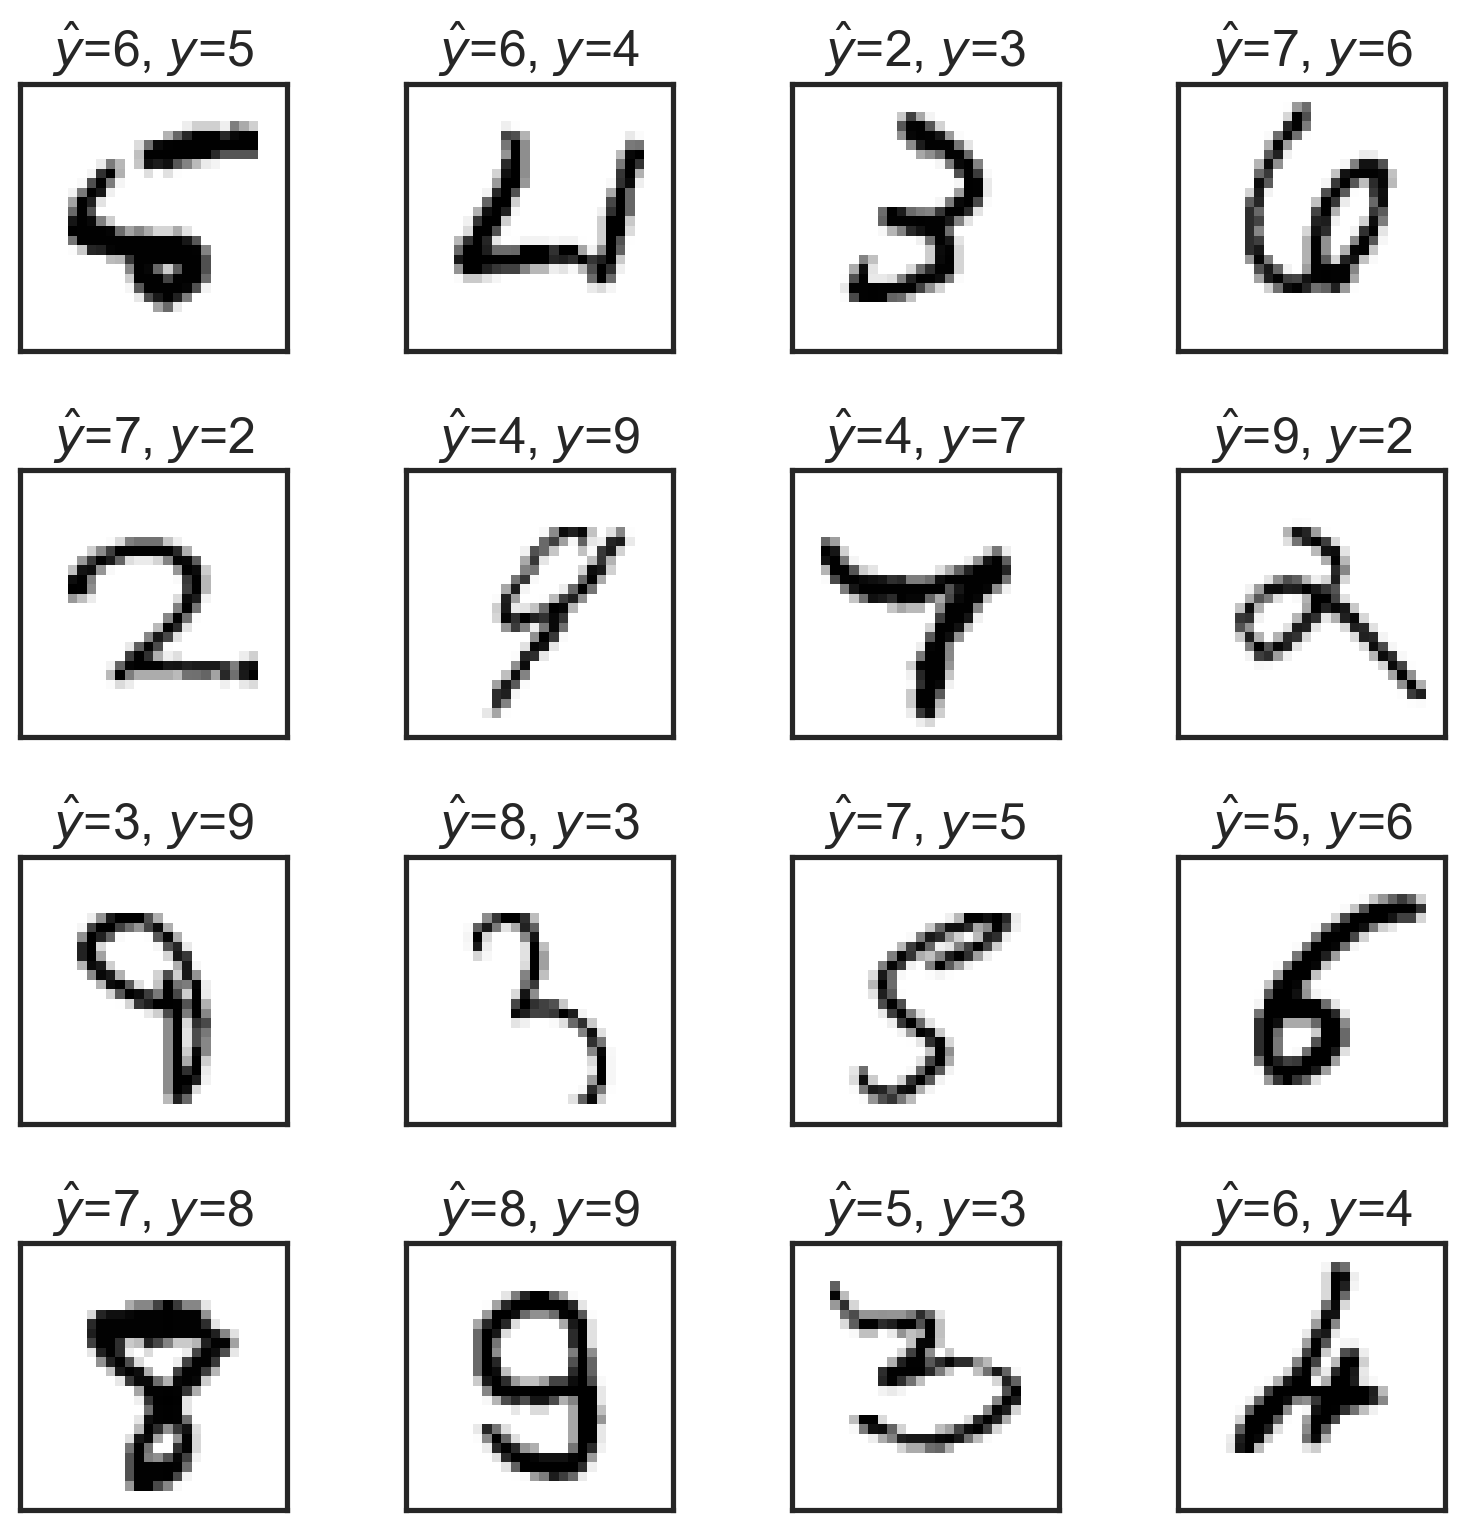

In [29]:
idx = (Y_true != Y_pred)
X_, Y_ = X_test[idx], Y_test[idx]
fig, axes = plt.subplots(4, 4, figsize=(8,8))
for i, ax in enumerate(axes.flat):
    display_image(X_[i].reshape(28, 28), ax=ax)
    ax.set_title('{}={}, {}={}'.format(r'$\hat{y}$', predict(W, X_[i])[0], r'$y$', Y_[i].argmax()))
fig.tight_layout()

How can we improve this result? 
Maybe we can generate more features? Interactions between pixels? Remove redundant pixels? 

Generating and selecting features may require a lot of work!
Can we automate this process?

This is the motivation for **artificial neural networks**.

# References

- ProbML - [Probabilistic Machine Learning: An Introduction](https://probml.github.io/pml-book/book1.html) by Kevin P. Murphy. Online version. June 26, 2024
- Pawitan Y, 2001. *In all likelihood: statistical modelling and inference using likelihood*. **Ch. 6.1**.

# Colophon
This notebook was written by [Yoav Ram](http://www.yoavram.com).

This work is licensed under a CC BY-NC-SA 4.0 International License.